National Research University "Higher School of Economics"

Master of Data Science Online Programme

Course: Applied Statistics

Final Project: Treatment for Malocclusion

Student: Andrei Batyrov (Fall2022)

Date: 17-Oct-2023

##### Table of Contents

1. [Description](#description)

2. [Assignment](#assignment)

    2.1. [Causal effect of Treatment on dANB](#treat_danb)

    2.2. [Causal effect of Treatment on Growth](#treat_growth)

3. [Discussion](#discussion)

---
##### <a id="description"></a>1. Description

In this assignment you are going to analyse scull measurement data of patients with malocclusion. Patients affected by Class III malocclusion (characterised by the protrusion of lower dental arch) suffer from a skeletal imbalance that is established early in life, and that becomes more pronounced during puberty and until skeletal maturation is complete. Predicting treatment success or failure early in a single Class III patient makes it easier to correct it, but it is difficult to do just from a small number of morphometric determinants is problematic. The reason for that is that Class III malocclusion is rarely a consequence of an abnormality in a single craniofacial component, so individual clinical and radiological measurements are likely to be less indicative than the interplay between the measurements themselves.

The data set we will use contains 143 patients with two sets of measurements at ages T1 and T2 (measured in years) for the following variables:
- Treatment: untreated (0) or treated (1)
- Growth: a binary variable with values Good or Bad, determined on the basis of CoGn-CoA
- ANB: angle between Down's points A and B (degrees)
- IMPA: incisor-mandibular plane angle (degrees)
- PPPM: palatal plane - mandibular plane angle (degrees)
- CoA: total maxillary length from condilion to Down's point A (mm)
- GoPg: length of mandibular body from gonion to pogonion (mm)
- CoGo: length of mandibular ramus from condilion to pogonion (mm)

All the measurements are taken from x-ray scans using a set of reference points established using a map like the following:

<img src="skull.png"/>

Fig. 1. Skull map

For simplicity, we transform the dataset by taking differences between time points T2 and T1, so all features now represent changes in measurements:
`malocclusion.csv`
We would like to estimate the effect of the treatment on Growth and dANB by taking into account causal relationships between variables. Our knowledge of those causal relationships is represented on the following DAG:

<img src="DAG.png" width="533" height="500"/>

Fig. 2. Causal DAG

Treatment assignment, Growth and number of years between two measurements are likely to be affected by some unobserved confounders, as the graph shows.

Given the graph, select the variables to condition on, apply suitable adjustment method, and calculate your estimates of causal effects: Treatment on Growth, Treatment on dANB, both ATE and ATET.

Your analysis should contain:

- Selection of covariates to adjust for (informed by the graph)
- Application of the most suitable adjustment method
- Estimates of the ATE and ATET

The maximal grade for the assignment is 25 points , where for each of two estimated causal effects you could get:
- a maximum of 6.5 points for correct and optimal selection of the adjustment set,
- a maximum of 3 points for correct estimation of the ATE,
- a maximum of 3 points for correct estimation of the ATET.

---
##### <a id="assignment"></a>2. Assignment

In [26]:
# Essential import
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LinearRegression
from causalinference import CausalModel
from scipy.stats import ttest_rel
import matplotlib.pyplot as plt
alpha = 0.05 # significance level

In [27]:
# Load data
malocclusion_data = pd.read_csv('malocclusion.csv')
malocclusion_data.head()

,dANB,dPPPM,dIMPA,dCoA,dGoPg,dCoGo,dT,Growth,Treatment
0,-3.2,-1.1,-4.2,1.0,4.0,3.7,5,0,0
1,-0.6,-0.5,3.8,2.6,-0.1,1.4,3,1,0
2,-1.6,-3.1,-6.0,4.3,4.2,7.1,5,0,0
3,-1.1,-2.1,-12.1,14.1,20.7,17.5,9,0,0
4,-1.1,0.0,-6.7,7.7,8.8,11.0,5,0,0


In [28]:
malocclusion_data.shape

(143, 9)

In [29]:
malocclusion_data.describe()

,dANB,dPPPM,dIMPA,dCoA,dGoPg,dCoGo,dT,Growth,Treatment
count,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000
mean,-0.227273,-1.374825,-0.785315,5.987413,7.730769,6.732867,4.706294,0.405594,0.461538
std,1.826225,2.715046,5.080894,4.469692,5.532417,4.595141,2.550427,0.492733,0.500271
min,-5.100000,-9.300000,-19.000000,-0.900000,-1.400000,-2.600000,1.000000,0.000000,0.000000
25%,-1.350000,-2.750000,-3.450000,1.800000,3.200000,3.050000,3.000000,0.000000,0.000000
50%,-0.300000,-1.400000,-0.400000,5.500000,6.200000,6.300000,4.000000,0.000000,0.000000
75%,0.950000,0.050000,2.100000,9.750000,12.750000,10.350000,6.000000,1.000000,1.000000
max,4.900000,6.500000,12.000000,20.000000,23.300000,17.500000,12.000000,1.000000,1.000000


In [30]:
malocclusion_data.dtypes

dANB         float64
dPPPM        float64
dIMPA        float64
dCoA         float64
dGoPg        float64
dCoGo        float64
dT             int64
Growth         int64
Treatment      int64
dtype: object

In [31]:
malocclusion_data.isna().sum()

dANB         0
dPPPM        0
dIMPA        0
dCoA         0
dGoPg        0
dCoGo        0
dT           0
Growth       0
Treatment    0
dtype: int64

##### <a id="treat_danb"></a>2.1 Causal effect of Treatment on dANB

Let's determine our variables:
- $X$: valid adjustment set of known factors,
- $T$: treatment factor, which is `Treatment` in our case,
- $Y$: potential outcome, which is `dANB` in our case.

As per the DAG in Fig. 1, there are several factors that can influence the potential outcome, besides the treatment itself, which we need to adjust for. Factors `dIMPA`, `dGoPg`, `dCoGo` with their descendants `dCoA` and `dPPPM` are colliders and thus may introduce bias. The only collider-free undirected path from `Treatment` from `dANB` is `Treatment` $\rightarrow$ `Unobserved confounders` $\rightarrow$ `dT` $\rightarrow$ `Growth` $\rightarrow$ `dANB`, with `dT` and `Growth` being the blockers on the path. A set of these factors 1) do not have any descendants on the directed path from `Treatment` to `dANB` (except for descendants of `Treatment` that are not on the directed path from `Treatment` to `dANB`), 2) blocks all undirected paths from `Treatment` to `dANB`, which makes it a valid adjustment set. Since, we do not know, and thus cannot adjust for `Unobserved confounders`, we will not include it in our final adjustment set.

So, our final variables are:
- $X$ = {`dT`, `Growth`},
- $T$ = `Treatment`,
- $Y$ = `dANB`.

As a baseline approach, let's calculate unadjusted average treatment effect (ATE) on our outcome. This effect is likely to be biased, since we do not account for other factors, as per our adjustment set.

In [32]:
X = ['dT', 'Growth']
T = 'Treatment'
Y = 'dANB'

In [33]:
y_avg_t0 = malocclusion_data[Y][malocclusion_data[T] == 0].mean()
y_avg_t1 = malocclusion_data[Y][malocclusion_data[T] == 1].mean()

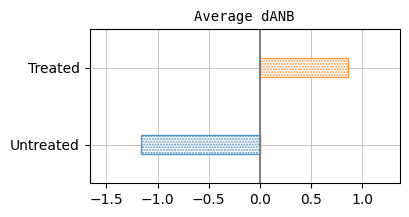

In [34]:
plt.figure(figsize=(4, 2))
bars = plt.barh(['Untreated', 'Treated'], [y_avg_t0, y_avg_t1], height=0.25, align='center', color = 'white', edgecolor='C2', alpha=0.75, hatch='.'*6)
plt.vlines(0, -0.5, 1.5, color='C7')
plt.xlim([min(y_avg_t1, y_avg_t0) - 0.5, max(y_avg_t1, y_avg_t0) + 0.5])
plt.ylim([-0.5, 1.5])
plt.title('Average dANB', size=10, family='monospace')
for i in range(len(bars)):
    bars[i].set_edgecolor(f'C{i}')
plt.gca().set_axisbelow(True)
plt.grid(lw=0.5)

In [35]:
ATE_unadj = y_avg_t1 - y_avg_t0
print(f'ATE on dANB (Unadjusted) = {ATE_unadj:.2f}')

ATE on dANB (Unadjusted) = 2.03


Next we will apply several adjustment methods.

1. Ordinary Linear Regression

In [36]:
model_linreg = smf.ols(f"{Y} ~ {' + '.join([T] + X)}", data=malocclusion_data)
fitted = model_linreg.fit()
print(fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                   dANB   R-squared:                       0.409
Model:                            OLS   Adj. R-squared:                  0.397
Method:                 Least Squares   F-statistic:                     32.12
Date:                Tue, 17 Oct 2023   Prob (F-statistic):           7.78e-16
Time:                        03:40:04   Log-Likelihood:                -250.87
No. Observations:                 143   AIC:                             509.7
Df Residuals:                     139   BIC:                             521.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.4021      0.276     -5.075      0.0

In [37]:
print(f"Statistically significant OLS model's coefficients ({alpha = }):")
print(fitted.params[fitted.pvalues <= alpha].to_string(header=None))
ATE_OLS = fitted.params.loc['Treatment']
print(f'R-squared = {fitted.rsquared:.2f}')
print(f"ATE on dANB (OLS) = {ATE_OLS:.2f}")

Statistically significant OLS model's coefficients (alpha = 0.05):
Intercept   -1.402079
Treatment    1.933583
Growth       1.144324
R-squared = 0.41
ATE on dANB (OLS) = 1.93


Notes:
- though `Treatment` is a statistically significant factor, $R^2 \approx 0.41$, that is the ordinary linear model can explain only around 41% of variance of `dANB`, which means that it is not a very good estimator, thus ATE can still be biased (!);
- `dT` appeared to be a statistically non-significant factor.

2. Weighted Linear Regression with propensity score weighting

In [38]:
# Classifier to estimate the propensity scores
model_logreg = LogisticRegression()
# Calibrate the classifier
model_logreg = CalibratedClassifierCV(model_logreg)
# Fit the classifier for X and T
model_logreg.fit(malocclusion_data[X], malocclusion_data[T])
# Calculate propensity scores
malocclusion_data['e'] = model_logreg.predict_proba(malocclusion_data[X])[:, 1].tolist()
# Calculate wights
malocclusion_data['w'] = malocclusion_data[T] / malocclusion_data['e'] + (1 - malocclusion_data[T]) / (1 - malocclusion_data['e'])
malocclusion_data.head()

,dANB,dPPPM,dIMPA,dCoA,dGoPg,dCoGo,dT,Growth,Treatment,e,w
0,-3.2,-1.1,-4.2,1.0,4.0,3.7,5,0,0,0.438002,1.779366
1,-0.6,-0.5,3.8,2.6,-0.1,1.4,3,1,0,0.432087,1.760832
2,-1.6,-3.1,-6.0,4.3,4.2,7.1,5,0,0,0.438002,1.779366
3,-1.1,-2.1,-12.1,14.1,20.7,17.5,9,0,0,0.646442,2.828388
4,-1.1,0.0,-6.7,7.7,8.8,11.0,5,0,0,0.438002,1.779366


Now, let's fit weighted linear regression model using the weights obtained above.

In [39]:
model_linreg = smf.wls(f"{Y} ~ {' + '.join([T] + X)}", data=malocclusion_data, weights=malocclusion_data['w'])
fitted = model_linreg.fit()
print(fitted.summary())

                            WLS Regression Results                            
Dep. Variable:                   dANB   R-squared:                       0.375
Model:                            WLS   Adj. R-squared:                  0.362
Method:                 Least Squares   F-statistic:                     27.83
Date:                Tue, 17 Oct 2023   Prob (F-statistic):           3.73e-14
Time:                        03:40:04   Log-Likelihood:                -261.69
No. Observations:                 143   AIC:                             531.4
Df Residuals:                     139   BIC:                             543.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.3302      0.310     -4.290      0.0

In [40]:
print(f"Statistically significant WLS model's coefficients ({alpha = }):")
print(fitted.params[fitted.pvalues <= alpha].to_string(header=None))
ATE_WLS = fitted.params.loc['Treatment']
print(f'R-squared = {fitted.rsquared:.2f}')
print(f"ATE on dANB (WLS) = {ATE_WLS:.2f}")

Statistically significant WLS model's coefficients (alpha = 0.05):
Intercept   -1.330168
Treatment    1.957926
Growth       1.039897
R-squared = 0.38
ATE on dANB (WLS) = 1.96


Notes:
- though `Treatment` is a statistically significant factor, $R^2 \approx 0.38$, that is the ordinary linear model can explain only around 38% of variance of `dANB`, which means that it is not a very good estimator, thus ATE can still be biased (!);
- `dT` appeared to be a statistically non-significant factor.

3. Doubly Robust estimator

In [41]:
# Build two linear models
y0 = LinearRegression().fit(
                            malocclusion_data[malocclusion_data[T] == 0][X], 
                            malocclusion_data[malocclusion_data[T] == 0][Y]) \
                        .predict(malocclusion_data[X])

y1 = LinearRegression().fit(
                            malocclusion_data[malocclusion_data[T] == 1][X], 
                            malocclusion_data[malocclusion_data[T] == 1][Y]) \
                            .predict(malocclusion_data[X])

# Calculate DR estimator
malocclusion_data['DR0'] = (1 - malocclusion_data[T]) * (malocclusion_data[Y] - y0) / (1 - malocclusion_data['e']) + y0
malocclusion_data['DR1'] = malocclusion_data[T]  * (malocclusion_data[Y] - y1) / malocclusion_data['e']  + y1
ATE_DR = malocclusion_data['DR1'].mean() - malocclusion_data['DR0'].mean()
print(f"ATE on dANB (DR) = {ATE_DR:.2f}")

ATE on dANB (DR) = 1.88


In [66]:
t_test = ttest_rel(malocclusion_data['DR1'], malocclusion_data['DR0'])
print(f'{t_test.statistic = :.2f}\n{t_test.pvalue = :.2e} ({alpha = })\n95% CI = {list(map(lambda x: round(x, 2), t_test.confidence_interval()))}')

t_test.statistic = 7.03
t_test.pvalue = 8.12e-11 (alpha = 0.05)
95% CI = [1.35, 2.41]


Notes:
- `ATE` is statistically significant.
- The estimate still can be biased, since linear regression is used.

4. Matching with Machalanobis distance

In [18]:
model_causal = CausalModel(Y=malocclusion_data[Y].values, D=malocclusion_data[T].values, X=malocclusion_data[X].values)
model_causal.est_via_matching(bias_adj=True)
print(model_causal.estimates)


Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      1.887      0.361      5.222      0.000      1.179      2.596
           ATC      1.759      0.407      4.320      0.000      0.961      2.557
           ATT      2.037      0.474      4.297      0.000      1.108      2.967



c:\Users\andre\mambaforge\lib\site-packages\causalinference\estimators\matching.py:100: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return np.linalg.lstsq(X, Y)[0][1:]  # don't need intercept coef


In [19]:
ATE_Mach = model_causal.estimates['matching']['ate']
ATET_Mach = model_causal.estimates['matching']['att']
print(f" ATE on dANB (Causal model) = {ATE_Mach:.2f}")
print(f"ATET on dANB (Causal model) = {ATET_Mach:.2f}")

 ATE on dANB (Causal model) = 1.89
ATET on dANB (Causal model) = 2.04


Note: Both `ATE` and `ATET` are statistically significant.

5. Matching with Propensity scores

In [20]:
model_causal = CausalModel(Y=malocclusion_data[Y].values, D=malocclusion_data[T].values, X=malocclusion_data['e'].values)
model_causal.est_via_matching(bias_adj=True)
print(model_causal.estimates)


Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      1.844      0.361      5.113      0.000      1.137      2.551
           ATC      1.535      0.453      3.386      0.001      0.647      2.424
           ATT      2.204      0.401      5.502      0.000      1.419      2.989



In [21]:
ATE_e = model_causal.estimates['matching']['ate']
ATET_e = model_causal.estimates['matching']['att']
print(f" ATE on dANB (Causal model) = {ATE_e:.2f}")
print(f"ATET on dANB (Causal model) = {ATET_e:.2f}")

 ATE on dANB (Causal model) = 1.84
ATET on dANB (Causal model) = 2.20


Note: Both `ATE` and `ATET` are statistically significant.

Now let's compare our results and discuss them.

In [22]:
ATEs_df = pd.DataFrame({'ATE': [ATE_unadj, ATE_OLS, ATE_WLS, ATE_DR, ATE_Mach, ATE_e], 
                        'ATET': [np.nan, np.nan, np.nan, np.nan, ATET_Mach, ATET_e]}, 
                        index=['Unadjusted', 'OLS', 'WLS', 'DR', 'Machalanobis', 'e'])
ATEs_df

,ATE,ATET
Unadjusted,2.028788,NaN
OLS,1.933583,NaN
WLS,1.957926,NaN
DR,1.880615,NaN
Machalanobis,1.887357,2.037244
e,1.843778,2.203602


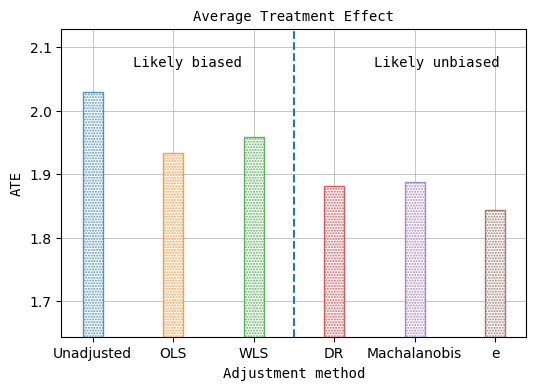

In [65]:
plt.figure(figsize=(6, 4))
bars = plt.bar(ATEs_df.index, ATEs_df['ATE'], width=0.25, align='center', color = 'white', edgecolor='C2', alpha=0.75, hatch='.'*6)
plt.vlines(2.5, ymin=ATEs_df['ATE'].min() - 0.2, ymax=ATEs_df['ATE'].max() + 0.1, ls='--')
plt.text(0.5, ATEs_df['ATE'].max() + 0.04, 'Likely biased', size=10, family='monospace')
plt.text(3.5, ATEs_df['ATE'].max() + 0.04, 'Likely unbiased', size=10, family='monospace')
plt.xlabel('Adjustment method', size=10, family='monospace')
plt.ylabel('ATE', size=10, family='monospace')
plt.title('Average Treatment Effect', size=10, family='monospace')
plt.ylim([ATEs_df['ATE'].min() - 0.2, ATEs_df['ATE'].max() + 0.1])
for i in range(len(bars)):
    bars[i].set_edgecolor(f'C{i}')
plt.gca().set_axisbelow(True)
plt.grid(lw=0.5)


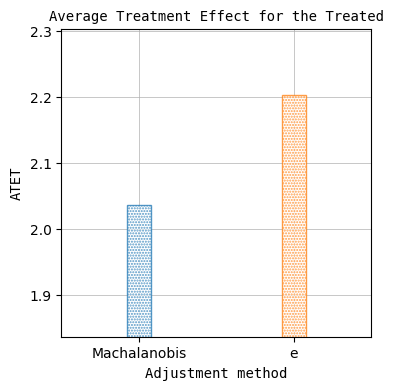

In [24]:
plt.figure(figsize=(4, 4))
bars = plt.bar(ATEs_df.index, ATEs_df['ATET'], width=0.15, align='center', color = 'white', edgecolor='C2', alpha=0.75, hatch='.'*6)
plt.xlabel('Adjustment method', size=10, family='monospace')
plt.ylabel('ATET', size=10, family='monospace')
plt.title('Average Treatment Effect for the Treated', size=10, family='monospace')
#plt.xticks(range(ATEs_df.shape[0]), ATEs_df.index)
plt.xlim([3.5, 5.5])
plt.ylim([ATEs_df['ATET'].min() - 0.2, ATEs_df['ATET'].max() + 0.1])
for i in range(len(bars)):
    bars[i].set_edgecolor(f'C{i+6}')
plt.gca().set_axisbelow(True)
plt.grid(lw=0.5)

##### <a id="treat_growth"></a>2.2 Causal effect of Treatment on Growth